In [22]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EVT 

In [23]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [24]:
def bg_cum_dist(z: np.ndarray, z_star: float, beta: float, gamma: float) -> np.ndarray:
    return np.exp(-(gamma/beta*(z-z_star))**(-1/gamma))

def bg_pdf_dist(z: np.ndarray, z_star: float, beta: float, gamma: float):
    return 1/beta * (gamma/beta*(z-z_star))**(-1/gamma -1) * np.exp(-(gamma/beta*(z-z_star))**(-1/gamma))

def gev_pdf_dist(z: np.ndarray, alpha: float, beta: float, gamma: float):
    return 1/beta * (1 + gamma * (z - alpha)/beta)**(-1/gamma -1) * np.exp(-(1 + gamma * (z - alpha)/beta)**(-1/gamma))

def z_star_from_alpha_beta_gamma(alpha: float, beta: float, gamma: float):
    return alpha - beta/gamma

def alpha_from_z_star_beta_gamma(z_star: float, beta: float, gamma: float):
    return z_star + beta/gamma

# def bg_log_likelihood(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     return -np.sum(np.log(beta) + (1/gamma + 1 ) * np.log(gamma/beta*(z-z_star)) - (gamma/beta*(z-z_star))**(-1/gamma))

# def bg_ll_jac(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     jac = np.zeros([2])
#     # dll/beta
#     jac[0] = -np.sum(1/beta - (1/gamma +1) / (gamma/beta*(z-z_star)) * gamma/beta -(gamma/beta*(z-z_star))**(-1/gamma -1))
#     jac[1] = -np.sum()
#     return jac

#\log\left(\mathcal{L}\left(z; z^{*}, \beta, \gamma\right)\right) & = & - n \log \beta - \left(1+\frac{1}{\gamma}\right)\sum_{i=1}^{n} \log\left(2+\frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right) \\ &&- \sum_{i=1}^{n}\left(2+ \frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right)^{-\frac{1}{\gamma}}.

In [25]:
pdfs = bg_pdf_dist(np.array([1,2,3]), 4, 1, -0.5)
pdfs

array([0.15809884, 0.36787944, 0.38940039])

In [26]:
# np.log(pdfs), np.sum(np.log(pdfs)), bg_log_likelihood(np.array([1, 2, 3]), 4, 1, -0.5)

In [27]:
import numpy as np

@np.vectorize
def ll_gamma(gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, 1, gamma)))


@np.vectorize
def ll_beta(beta: float = 1) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, -0.5)))

@np.vectorize
def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, gamma)))

@np.vectorize
def ll_alpha_beta_gamma(alpha: float = 4, beta: float = 1, gamma: float = -0.5) -> float:
    return np.sum(np.log(gev_pdf_dist(np.array([1, 2, 3]), alpha, beta, gamma)))

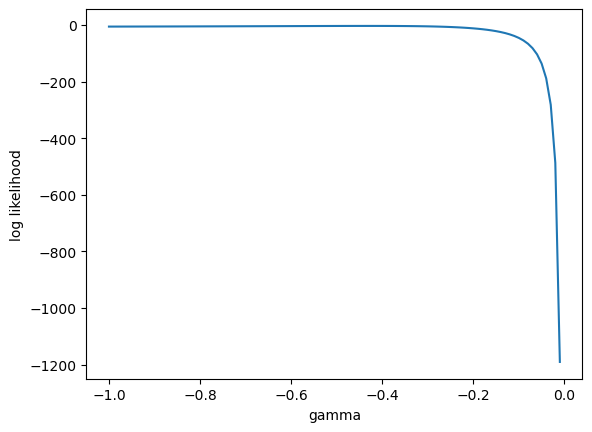

In [28]:
gammas = np.linspace(-1, -0.01, 100)
lls = ll_gamma(gammas)

plt.plot(gammas, lls)
plt.xlabel('gamma')
plt.ylabel('log likelihood')
plt.show()

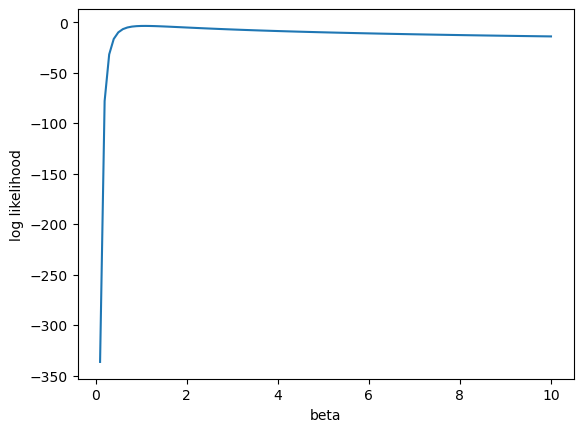

In [29]:
betas = np.linspace(0.1, 10, 100)
lls = ll_beta(betas)
plt.plot(betas, lls)
plt.xlabel("beta")
plt.ylabel("log likelihood")
plt.show()

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/1464497232.py:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf_dist(np.array([1, 2, 3]), 4, beta, gamma)))


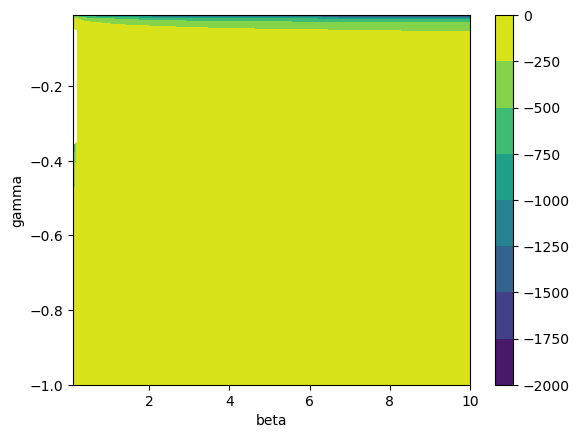

In [30]:
betas = np.linspace(0.1, 10, 100)
gammas = np.linspace(-1, -0.01, 100)
betas, gammas = np.meshgrid(betas, gammas)

lls = ll_beta_gamma(betas, gammas)

plt.contourf(betas, gammas, lls)
plt.xlabel("beta")
plt.ylabel("gamma")
plt.colorbar()

In [31]:
z = np.array([1, 2, 3, 4, 5])
z_star = 6

In [32]:
from scipy.optimize import minimize

In [33]:
mins = minimize(
    lambda x: -ll_beta_gamma(x[0], x[1]),
    x0=[1, -0.5],
    bounds=[(0.01, None), (None, -0.01)],
)


Text(0.5, 0, 'Return Period [years]')

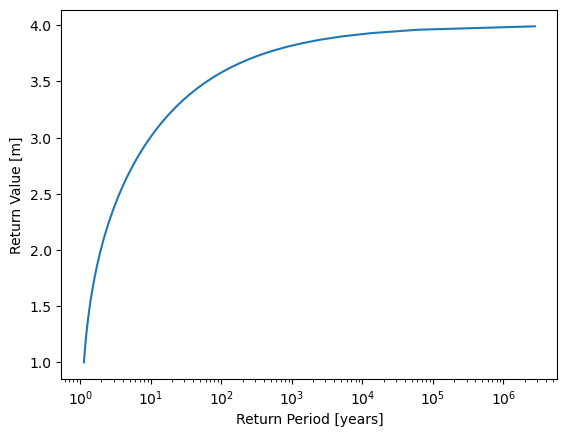

In [34]:
znew = np.linspace(1, 3.99, num=100)
rp = 1 / (1 - bg_cum_dist(znew, 4, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

In [35]:
znew = np.linspace(4, 5.99, num=100)

rp = 1 / (1 - bg_cum_dist(znew, z_star, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

In [36]:
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults
plot_defaults()

Text(0.5, 0, 'Return Period [years]')

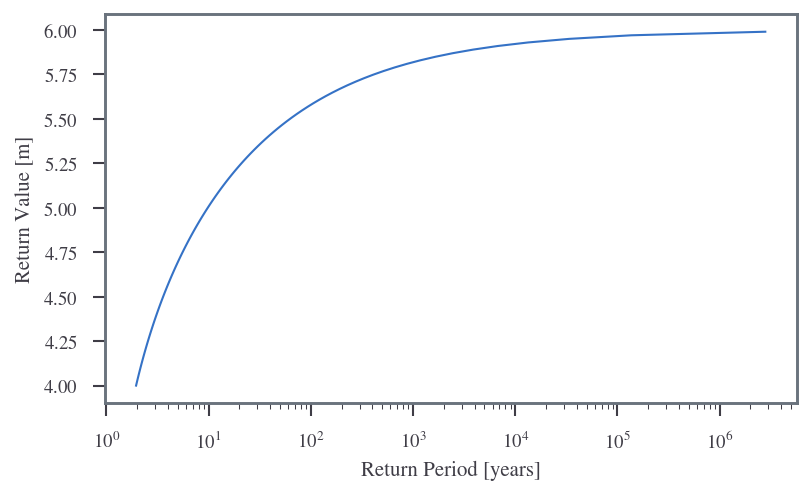

In [37]:
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")
# plot a horizontal line at z_star


In [89]:
from scipy.stats import genextreme
from typing import Tuple

def gen_samples_from_gev(z_star: float, beta: float, gamma: float, n: int):
    return genextreme.rvs(loc=alpha_from_z_star_beta_gamma(z_star, beta, gamma), scale=beta, c=-gamma, size=n)


def return_ll_beta_gamma(z: np.ndarray, z_star: float):
    @np.vectorize
    def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
        return np.sum(np.log(bg_pdf_dist(z, z_star, beta, gamma)))
    return ll_beta_gamma


def return_ll_alpha_beta_gamma(z: np.ndarray):
    @np.vectorize
    def ll_alpha_beta_gamma(
        alpha: float = 4, beta: float = 1, gamma: float = -0.5
    ) -> float:
        return np.sum(np.log(gev_pdf_dist(z, alpha, beta, gamma)))

    return ll_alpha_beta_gamma


def min_ll_beta_gamma(z: np.ndarray, z_star: float) -> Tuple[float, float]:
    mins = minimize(
        lambda x: -return_ll_beta_gamma(z, z_star)(x[0], x[1]),
        x0=[1, -0.5],
        bounds=[(0.01, None), (None, -0.01)],
    )
    return mins.x[0], mins.x[1]

def min_ll_alpha_beta_gamma(z: np.ndarray, bounded: bool = True) -> Tuple[float, float, float]:
    if bounded:
        tup = (None, -0.01)
    else:
        tup = (None, None)
    mins = minimize(
        lambda x: -return_ll_alpha_beta_gamma(z)(x[0], x[1], x[2]),
        x0=[4, 1, -0.3],
        bounds=[(None, None), (0.01, None), tup],
        jac='3-point',
        hess='3-point',
        
    )
    return mins.x[0], mins.x[1], mins.x[2]

/Users/simon/micromamba/envs/tcpips/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/4261289360.py:8: RuntimeWarning: invalid value encountered in power
  return 1/beta * (1 + gamma * (z - alpha)/beta)**(-1/gamma -1) * np.exp(-(1 + gamma * (z - alpha)/beta)**(-1/gamma))
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/3487330383.py:20: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(gev_pdf_dist(z, alpha, beta, gamma)))


True: alpha=4.5, beta=1, gamma=-0.4, 1/100=6.602980133837946
Max known: alpha=4.5, beta=0.9279063191025877, gamma=-0.38316924542121994, 1/100=6.584462208780511
Max unknown: alpha=9.501264101704097, beta=0.48673664835668384, gamma=-10.201084724856326, 1/100=9.54897830676022
Unbounded: alpha=4.582280694687509, beta=1.033931855006449, gamma=-0.6418335582961442, 1/100=6.109082932828063


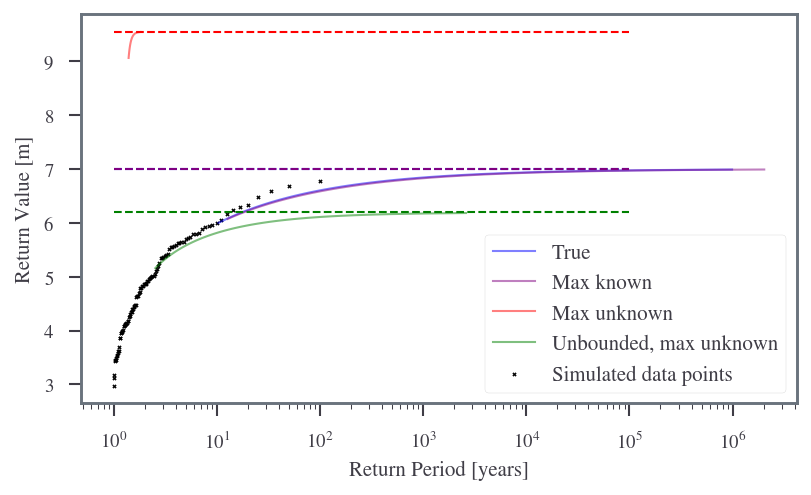

In [103]:
def plot_rp(alpha: float, beta: float, gamma: float, color: str = "blue", label=""):
    if gamma < 0: # Weibull class have upper bound
        z_star = z_star_from_alpha_beta_gamma(alpha, beta, gamma)
        plt.hlines(z_star, 1, 100_000, color=color, linestyles="dashed")
    znew = np.linspace(z_star-beta, z_star-beta*0.01, num=100)
    rp = 1 / (1 - bg_cum_dist(znew, z_star, beta, gamma))
    plt.semilogx(rp, znew, color=color, label=label, alpha=0.5)
    plt.ylabel("Return Value [m]")
    plt.xlabel("Return Period [years]")

def try_fit(z_star: float = 7, beta: float = 4, gamma: float = -0.1, n: int = 40) -> None:
    alpha = alpha_from_z_star_beta_gamma(z_star, beta, gamma)
    zs = gen_samples_from_gev(z_star, beta, gamma, n)
    bg_beta, bg_gamma = min_ll_beta_gamma(zs, z_star)
    bg_alpha = alpha_from_z_star_beta_gamma(z_star, bg_beta, bg_gamma) 
    f_alpha, f_beta, f_gamma = min_ll_alpha_beta_gamma(zs)
    u_alpha, u_beta, u_gamma = min_ll_alpha_beta_gamma(zs, bounded=False)
    print(f"True: alpha={alpha}, beta={beta}, gamma={gamma}, 1/100={genextreme.isf(1/100, c=-gamma, loc=alpha, scale=beta)}")
    print(f"Max known: alpha={alpha}, beta={bg_beta}, gamma={bg_gamma}, 1/100={genextreme.isf(1/100, c=-bg_gamma, loc=bg_alpha, scale=bg_beta)}")
    print(f"Max unknown: alpha={f_alpha}, beta={f_beta}, gamma={f_gamma}, 1/100={genextreme.isf(1/100, c=-f_gamma, loc=f_alpha, scale=f_beta)}")
    print(f"Unbounded: alpha={u_alpha}, beta={u_beta}, gamma={u_gamma}, 1/100={genextreme.isf(1/100, c=-u_gamma, loc=u_alpha, scale=u_beta)}")
    f_zstar = z_star_from_alpha_beta_gamma(f_alpha, f_beta, f_gamma)
    u_zstar = z_star_from_alpha_beta_gamma(u_alpha, u_beta, u_gamma)
    plot_rp(alpha, beta, gamma, color="blue", label="True")
    plot_rp(bg_alpha, bg_beta, bg_gamma, color="purple", label="Max known")
    plot_rp(f_alpha, f_beta, f_gamma, color="red", label="Max unknown")
    plot_rp(u_alpha, u_beta, u_gamma, color="green", label="Unbounded, max unknown")
    sorted_zs = np.sort(zs)
    empirical_rps = len(zs) / np.arange(1, len(zs) + 1)[::-1]
    plt.scatter(empirical_rps, sorted_zs, s=3, color="black", label="Simulated data points")
    plt.legend()


try_fit(z_star=7, beta=1, gamma=-0.4, n=100)
# try_fit(z_star=7, beta=4, gamma=-0.5, n=100)